<a href="https://colab.research.google.com/github/drewwint/Quant-Family-Collective-fMRI-stats/blob/main/DWinters_QFC_wb1_fMRI_task_GLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task-Based fMRI: Intuition for individual-level GLM on a single voxel
### Drew E. Winters, PhD.
#### Adapted from code provided by Dr. Luke Chang

This tutorial aims to provide an intuative sense of how the estimation of the BOLD timeseries is conducted using signal components of a task conducted in an fMRI.
It is important to consider how events related to that task can account for changes in the BOLD signal - this is why we use a task.

This step is conducted at the individual level (i.e., individual-level or first-level analyses) so that we can then conduct inferential statistics across participants (i.e., group-level or second-level analyses) to test our hypotheses.

Here, as a case example to build intuition, we examine one voxel to estimate the extend to which task events are linked to changes in BOLD in one voxel. The point of this tutorial, and starting with examining only one voxel, is to just get a sense of how to take task components to estimate the BOLD signal.

We will expand on this across the while brain in later tutorials where this same GLM will be applied to estimate the BOLD signal for each individual voxel of the brain.

# What we will cover

  - Convolving the HRF to task events
  
  - Building a design matrix

  - Estimating GLM

# Importing Packages



In [ ]:
# Installing package nltools
! pip install nltools &> /dev/null

from scipy import stats
import seaborn as sns
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from nltools.stats import regress
from nltools.external import glover_hrf

## Convolution: Linking Task Events to the Hemodynamic Response Function (HRF)

When participants complete a task in the fMRI where different stimuli are presented - for example either a face or an object is displayed - and each stimuli presentation is called an event.

The FMRI signal comes about by changes in the ratio of oxegenatied hemoblobin in the blood as a result of the demands required after neuronal firing. This is known as the blood oxegenated level dependent (BOLD) signal. In order to predict the BOLD signal in response to an event, we need a model of the task events that evoke changes in neuronal firing, and second we need a model of how the BOLD will respond.

So we have a two-stage problem:
    predict the event (a model of task events evoking neuronal firing);
    predict the BOLD (a model of HRF).

Convolution links task events to the HRF.

## HRF

First lets estimate a hypothetical HRF

Text(0.5, 1.0, 'Hemodynamic Response Function')

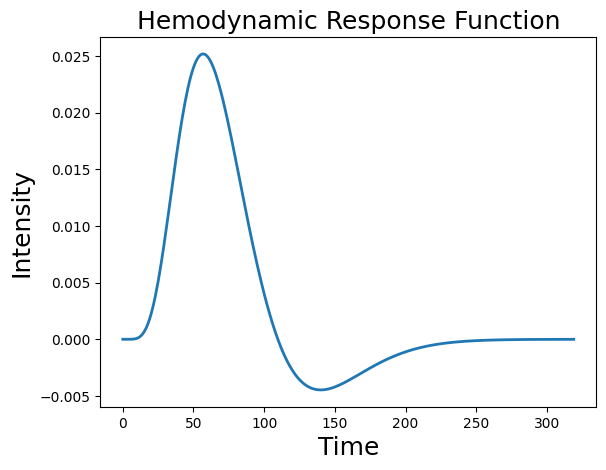

In [ ]:
# displaying a hypothetical HRF
tr = 2
hrf = glover_hrf(tr, oversampling=20)
plt.plot(hrf, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Hemodynamic Response Function', fontsize=18)

Note how smooth this is - we over sampled to make it nice and neat. In reality this changs is not as fluid. Lets make a new model without over sampling.

Text(0.5, 1.0, 'Hemodynamic Response Function')

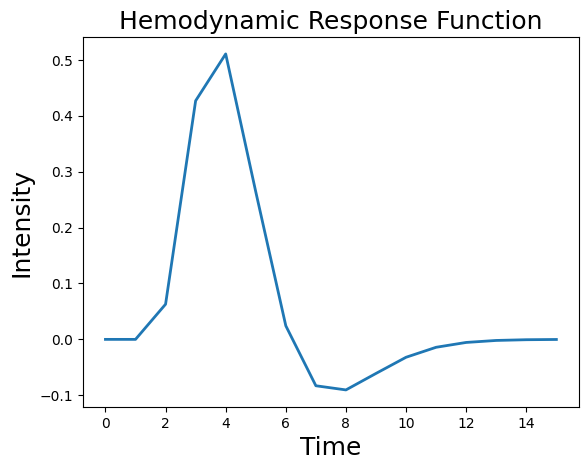

In [ ]:
tr = 2
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Hemodynamic Response Function', fontsize=18)

Now that we have our HRF modeled - lets make a hypothetical timeserie of some stimuli.

Note the stimuli we create below are evenly spaced and have a similar intensity - this is often not the case but we will use this as an example to build on later.

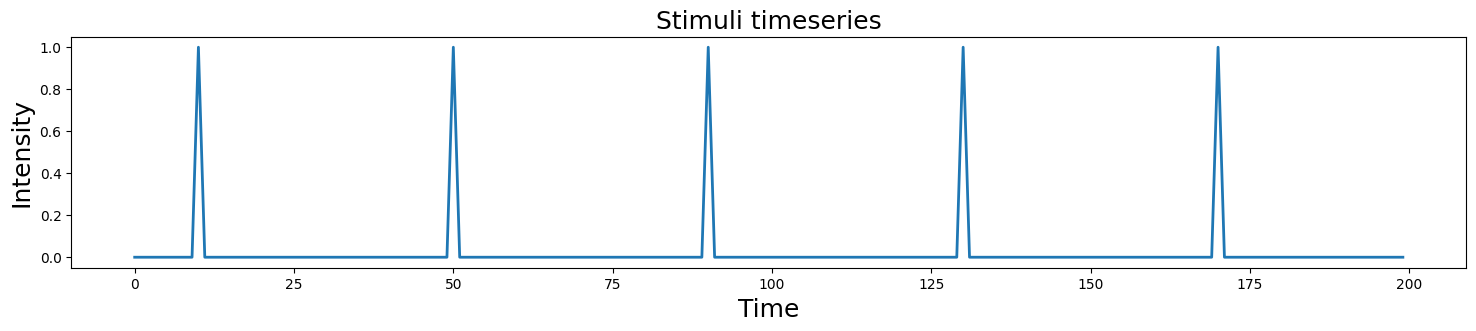

(None, None, None)

<Figure size 640x480 with 0 Axes>

In [ ]:
n_tr = 200
n_trial = 5
signal = np.zeros(n_tr)
np.random.seed(2020)
signal[np.arange(10, n_tr, int(n_tr/n_trial))] = 1


plt.figure(figsize=(18,3))
plt.plot(signal, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Stimuli timeseries', fontsize=18)
plt.show(), plt.close(), plt.clf()

## Convolution

Now lets perform the convolution using our HRF and stimuli timeseries.
to do this we will use np.convove() - a numpy function that iteratively computes the dot product between the stimuli events and the HRF over time.

The formula for the dot product is below. This dot product formula is used as a measure of how closely vectors align (can also be used for geometric mapping the product of magnitudes between two vectors and cosigne of the angle between them).

$dotproduct_{ab} = \sum_{i=1}^n a_ib_i$

- $a$	= 	1st vector
- $b$	= 	2nd vector
- $n$	= 	dimension of the vector space
- $a_i$	= 	component i of vector a
- $b_i$	= 	component i of vector b


Text(0.5, 1.0, 'Stimuli timeries convolved with HRF')

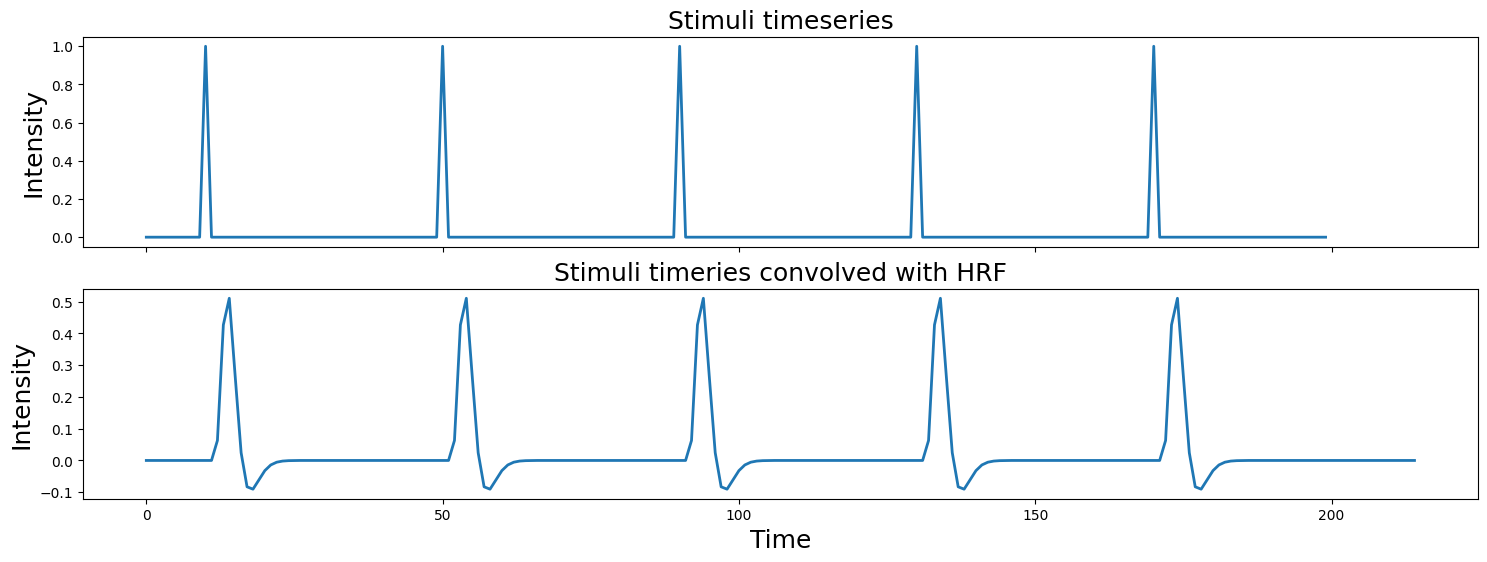

In [ ]:
conv = np.convolve(signal, hrf)## here we use np.convolve to generate expected HRF

f,a = plt.subplots(nrows=2, figsize=(18,6), sharex=True)
a[0].plot(signal, linewidth=2)
a[1].plot(conv, linewidth=2)
a[0].set_ylabel('Intensity', fontsize=18)
a[0].set_title('Stimuli timeseries', fontsize=18)
a[1].set_ylabel('Intensity', fontsize=18)
a[1].set_xlabel('Time', fontsize=18)
a[1].set_title('Stimuli timeries convolved with HRF', fontsize=18)

# Estimating BOLD from multiple task conditions

Lets create a new stimuli series involving two separate conditions and intensities.

Lets assume we want to identify which region of the brain is involved in processing faces. what will will have are two separate conditions involving the presentatoin of a face and the presentation of a non-face object for comparision. In such a task we could assume the intensity of the face would be greater than the object stimuli - so lets model it as such.

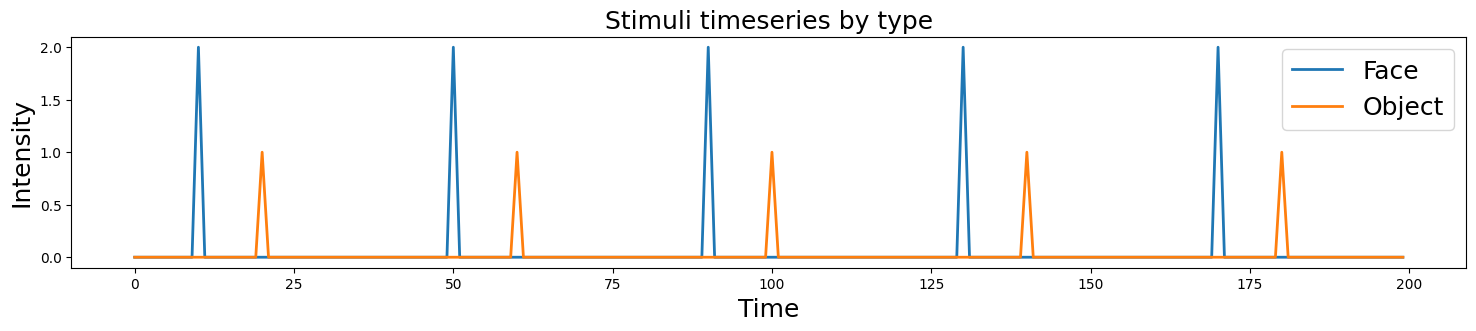

(None, None, None)

<Figure size 640x480 with 0 Axes>

In [ ]:
face_intensity = 2
object_intensity = 1

face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = face_intensity
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = object_intensity
voxel = np.vstack([face,obj]).T

plt.figure(figsize=(18,3))
plt.plot(voxel, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Stimuli timeseries by type', fontsize=18)
plt.legend(['Face', 'Object'], fontsize=18)
plt.show(), plt.close(), plt.clf()


Now we have conditions alternating over time.

We know the brain has a delayes HRF response to events with a particular shape - so we will convolve our HRF with these events

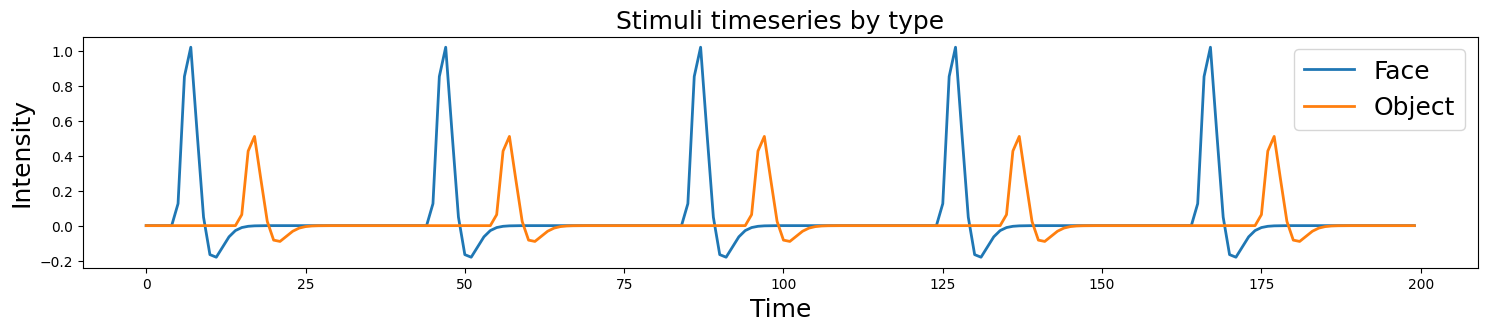

(None, None, None)

<Figure size 640x480 with 0 Axes>

In [ ]:
face_conv = np.convolve(face, hrf, mode='same')
obj_conv = np.convolve(obj, hrf, mode='same')
voxel_conv = np.vstack([face_conv, obj_conv]).T

plt.figure(figsize=(18,3))
plt.plot(voxel_conv, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Stimuli timeseries by type', fontsize=18)
plt.legend(['Face', 'Object'], fontsize=18)
plt.show(), plt.close(), plt.clf()

While this might reflect the expected HRF response to a single event, real data is much noiser. It is easy to add different types of noise. For example, there might be a low frequency drift, autocorrelation, or possibly some aliased physiological artifacts.

For now, let’s start with white noise drawn from a Gaussian distribution

$ϵ = 𝒩(μ, σ^2)$

- ϵ = epislon or error (we are adding error)
- 𝒩 = nu or normal distribution
- $μ$ = mu or mean
- $σ$ = sigma or variance

where $μ$ = 0 and $σ$ = 0.15


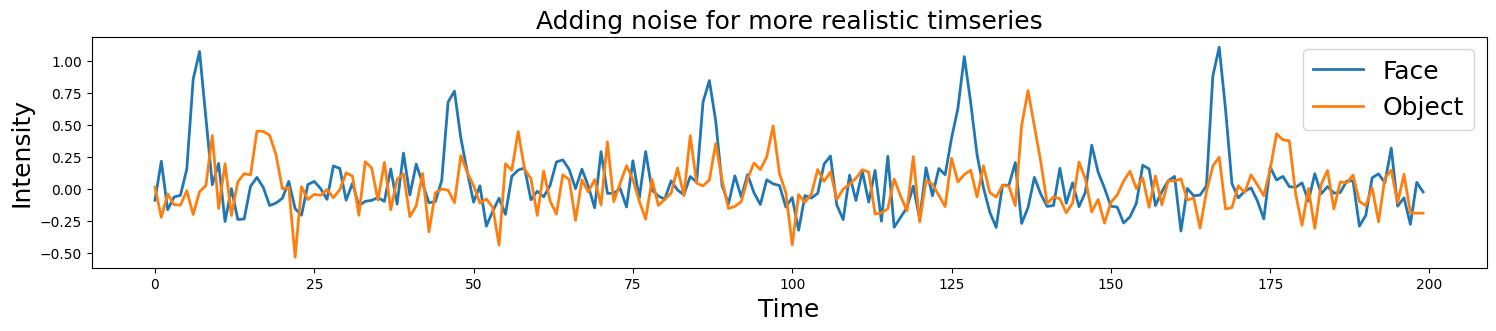

(None, None, None)

<Figure size 640x480 with 0 Axes>

In [ ]:
sigma = 0.15
np.random.seed(591)
epsilon = sigma*np.random.randn(n_tr, 2)
voxel_conv_noise = voxel_conv + epsilon

plt.figure(figsize=(18,3))
plt.plot(voxel_conv_noise, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Adding noise for more realistic timseries', fontsize=18)
plt.legend(['Face', 'Object'], fontsize=18)
plt.show(), plt.close(), plt.clf()

This is much more like real BOLD activity.

We are simuliting BOLD from a voxel. If this was real we wouldn’t know which condition was which at this point. So -- We wil combine these  signals into one simulated voxel timeseries by adding them.

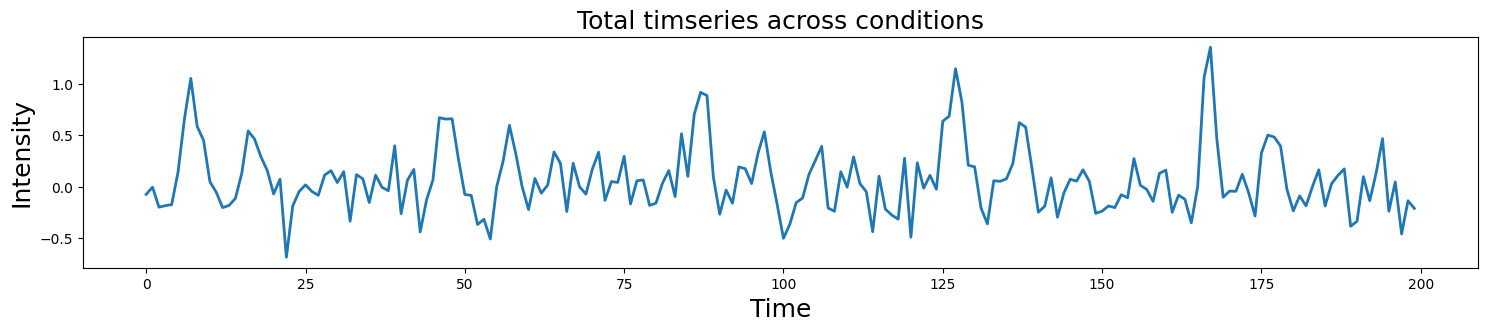

(None, None, None)

<Figure size 640x480 with 0 Axes>

In [ ]:
Y = voxel_conv_noise.sum(axis=1)

plt.figure(figsize=(18,3))
plt.plot(Y, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Total timseries across conditions', fontsize=18)
plt.show(), plt.close(), plt.clf()

## Constructing a Design Matrix

With our simulated data - lets see if we can recover the original signal using a general linear model in the following formula:

$Y = X\beta + \epsilon$
- $Y$ = observed voxel time series.
- $X$ = model or design matrix where we specify a predicted response to each condition.
- $\beta$ = vector of estimates to scale our model.
- $\epsilon$ = error.

This model decomposes $Y$ into a set of independent variables scaled by an estimated $\beta$ parameter that are summed together along with the $\epsilon$ parameter.

When we simulated the data we specified face amplitude, object amplitude, and $\epsilon$. So when hen we fit our model to the simulated data, we should in theory be able to almost perfectly recover these three parameters.

Now let’s build a design matrix $X$ using an intercept (just an arbitrary constant here *should be recovered as 0 in estimates*), and a regressor indicating the onset of each condition, convolved with the HRF.

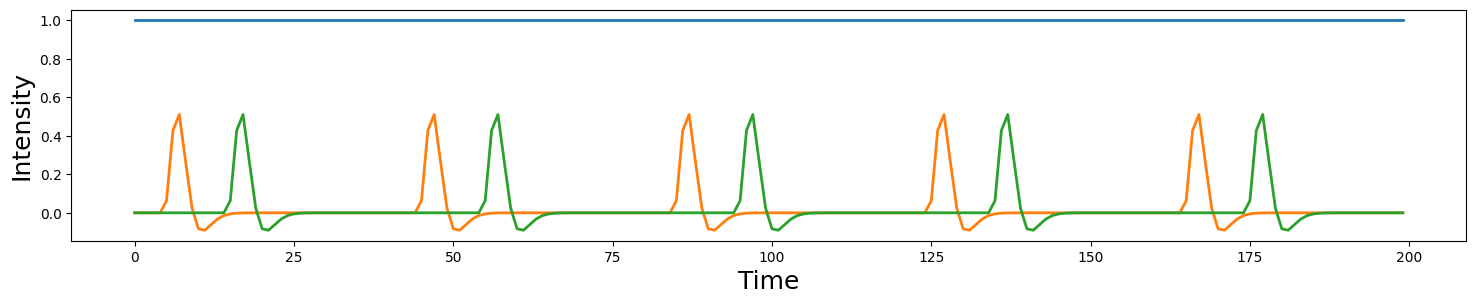

(None, None, None)

<Figure size 640x480 with 0 Axes>

In [ ]:

face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = 1
intercept = np.ones(n_tr)
X = np.vstack([intercept, np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T


plt.figure(figsize=(18,3))
plt.plot(X, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.show(), plt.close(), plt.clf()

Our model written out as an equation makes it clear what we are doing.

$Voxel = \beta_0 * Intercept + \beta_1 * Faces + \beta_2 * Objects + \epsilon$
- $\beta_0$ = weight for the Intercept
- $\beta_1$ = weight for estimating Faces
- $\beta_2$ = weight for estimating Objects
- $\epsilon$ = residual error

Below we display this graphically, which cleraly demonstrates how each of these components relate to our specified regression equation.

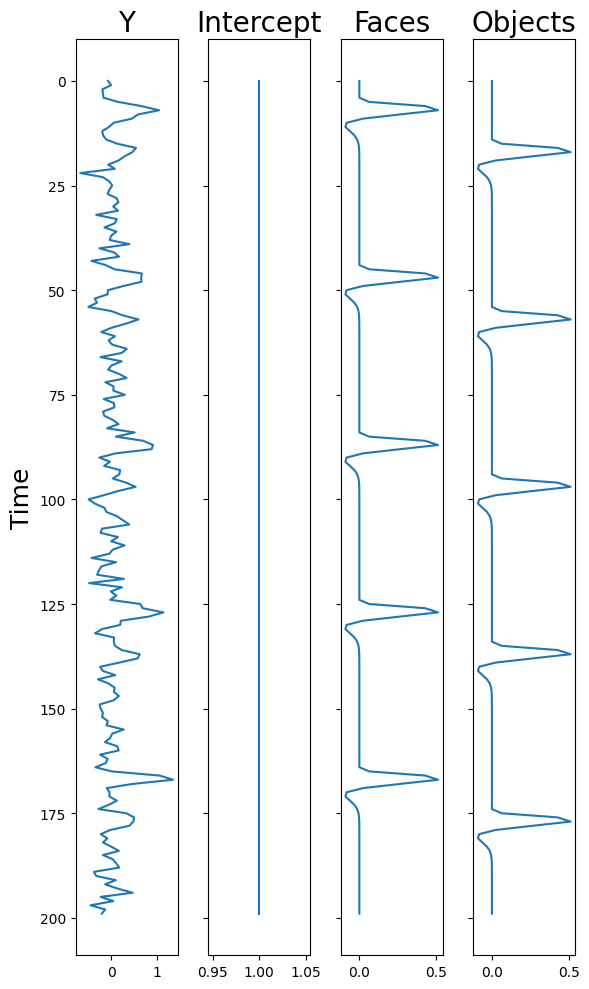

In [ ]:
f, a = plt.subplots(ncols=4, figsize=(6, 10), sharey=True)
a[0].plot(np.expand_dims(Y, axis=1), range(len(Y)))
a[1].plot(X[:,0], range(len(Y)))
a[2].plot(X[:,1], range(len(Y)))
a[3].plot(X[:,2], range(len(Y)))
a[0].set_ylabel('Time', fontsize=18)
a[0].set_title('Y', fontsize=20)
a[1].set_title('Intercept', fontsize=20)
a[2].set_title('Faces', fontsize=20)
a[3].set_title('Objects', fontsize=20)
plt.gca().invert_yaxis()
plt.tight_layout()

## Estimate GLM

With the simulated voxel timeseries $Y$ and the design matrix $X$, we can fit our model to the data by estimating the $\beta$ parameters for intercept, faces, and object.

Two popular ways to estimate the GLM include.

1. The Ordinary Least Squares (OLS) estimator finds the $\beta^̂$ hyperplane that minimizes the error between the observed and predicted.

  This can be formulated using linear algebra as:

\begin{align}
\beta^̂ = (X^TX)^{-1}X^TX
\end{align}

2. Maximum liklihood estimation - that results in the identical result to OLS when the error terms are distributed normally.

\begin{align}
L(\beta, \sigma^2) = \Pi_{t=1}^n \frac{1}{\sqrt{(2\pi \sigma^2)}}
\end{align}

where

\begin{align}
N(0,\sigma^2)
\end{align}

Additionally - recent approches implement a bayesian approache [see article by Amanda Mejia and collegues](https://doi.org/10.1080/01621459.2019.1611582).

We will focus on the OLS estimator. Because it is so simple, we will write our own OLS function using the linear algebra. We typically will use a premade function that is more efficient and will also calculate other necessary statistics such as standard errors etc. we do this manually here for demonstration.

For a more in depth overview of GLM estimation, watch this [video](https://www.youtube.com/watch?v=Ab-5AbJ8gAs) by Tor Wager and Martin Lindquist.

In [ ]:
def ols_estimator(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

beta = ols_estimator(X, Y)

predicted_y = np.dot(X, beta)

predicted_ts = np.vstack([Y, predicted_y]).T


## Evaluating Model

### Evaluating timeseries
We will evaluate how well our model is working is to plot our predicted $Y^̂$ on top of our simulated $Y$.

We can quantify the degree to which our model is accurately predicting the observed data by calculating the residual.

$residual = Y - Y^̂$

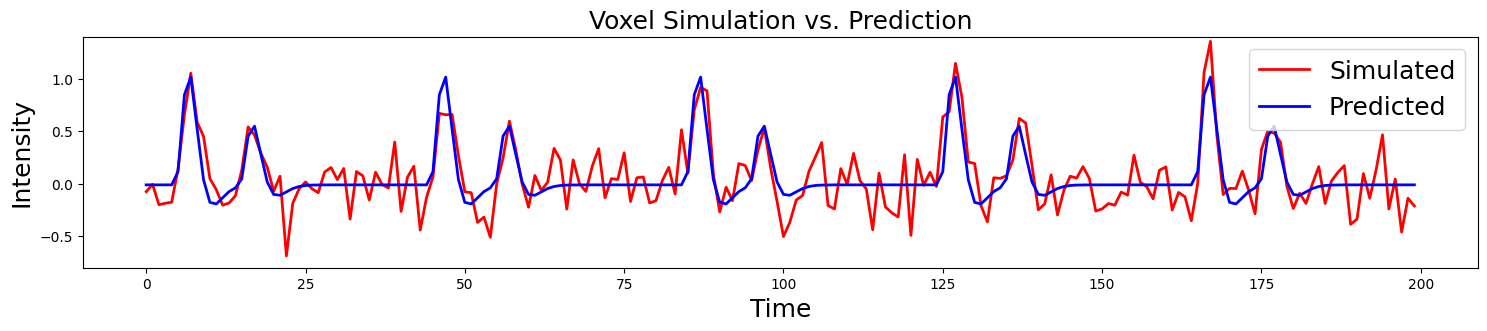

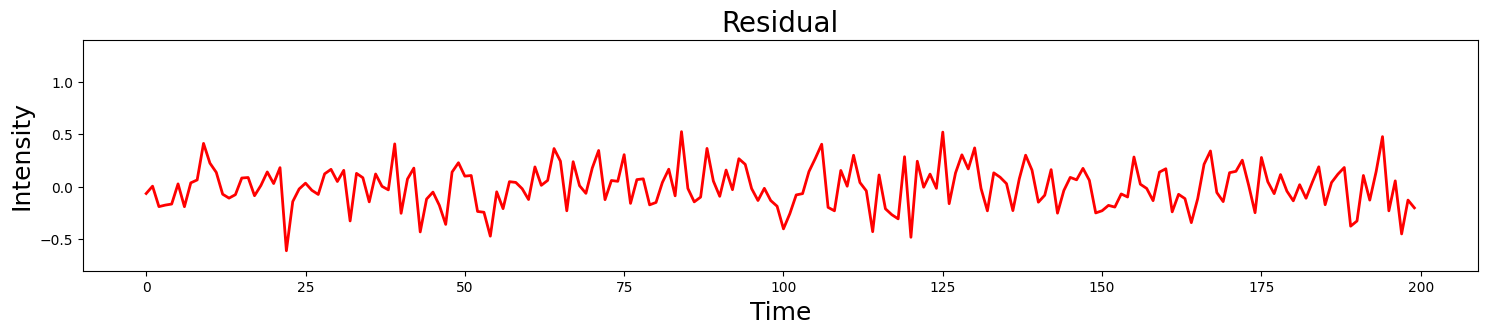

(None, None)

<Figure size 640x480 with 0 Axes>

In [ ]:

plt.figure(figsize=(18,3))
plt.plot(predicted_ts[:,0], linewidth=2, color = "r")
plt.plot(predicted_ts[:,1], linewidth=2, color = "b")
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(["Simulated","Predicted"], fontsize=18)
plt.title('Voxel Simulation vs. Prediction', fontsize=18)
plt.ylim(-0.8,1.4)
plt.show()

residual = Y - predicted_y

plt.figure(figsize=(18,3))
plt.plot(residual, linewidth=2, color = "r")
plt.title('Residual', fontsize=20)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.ylim(-0.8,1.4)
plt.show(), plt.clf()

### Standard Errors

The simulation data signal is being recovered failrly well by the OLS model.

The standard deviation of the residual is the standard error.

The formula for this is:

$\sigma^̂ = \sqrt{\frac{∑_i^n(Y^̂_i - Y_i)^2}{n-k}}$

- $n$ = number of observations
- $k$ = total number of regressors.
- $Σ$ = uppercase sigma meaning sum of terms
- $\sigma^̂$ = lowercase sigma hat or predicted variance
- $ŷ$ = y hat or predicted y
- $y$ = observed y
- $\sqrt{-}$ = square root

The better fitting model has the smaller the residual variance, or $\sigma^̂$.


As you can see, the residual variance $\sigma^̂$ is 0.2. which is only slightly higher than the 0.15 we simulated. This is likely because we do not have enought data in our simulation for true estimates.

Standard Error of the Estimate


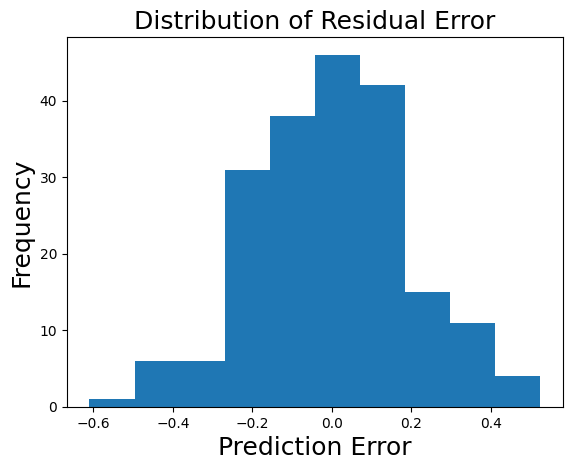

In [ ]:
standard_error_of_estimate = np.std(residual)

print(f"Standard Error of the Estimate")

plt.hist(residual)
plt.title('Distribution of Residual Error', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Prediction Error', fontsize=18)
plt.show()


### Explained Variance

While there are many metrics to describe how well a model fit the data...

Here we will calculate $R^2$ using the following formula:


$R^2 = 1- \frac{\sum_i^n(ŷ_i - y_i)^2}{\sum_i^n(y_i - y^̄)^2}$

- $y_i$ = value of the voxel at timepoint $i$
- $y^̂$ = predicted value for time point $i$
- $y^̄$ = mean of the measured voxel timeseries
- $Σ$ = uppercase sigma meaning sum of terms

$R^2$ is between $[0,1]$ indicating percentage of the total variance in $Y$ explained by $X$ (the model).


In [ ]:
def r_square(Y, predicted_y):
    SS_total = np.sum((Y - np.mean(Y))**2)
    SS_residual = np.sum((Y - predicted_y)**2)
    return 1-(SS_residual/SS_total)

print(f"R^2: {r_square(Y, predicted_y):.2}")

R^2: 0.61


## Evaluating Estimates

### Standard Error of $\beta$

The standard error around each specific estimate provides a degree of uncertainty about the $\beta$ value.

$\sigma = \sqrt{diag((X^TX)^-1)} * \sigma^̂$
- $^T$ = transpose
- $\sqrt{-}$ = square root
- $diag()$ = extracting the diagonal

Standard error are related to conficence intervals
- Confidence intervals specify a plausable value for a statisitc
- The standard error is the standard deviation of the sampling distribution (but not necessarly the emparical standard deviation).

One standard error, $1 * \sigma^̂$ is approximately equivalent to a 68% confidence interval, while $2 * \sigma^̂$ is approximately a 95% confidence interval.

difference between faces and objects: 0.91


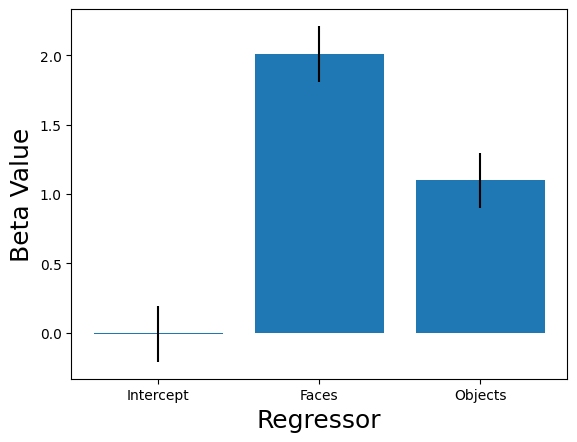

In [ ]:
std_error = np.sqrt(np.diag((np.linalg.pinv(np.dot(X.T, X))))) * standard_error_of_estimate

plt.bar(['Intercept','Faces', 'Objects'], beta, yerr = standard_error_of_estimate)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

print(f'difference between faces and objects: {beta[1]-beta[2]:.2}')

## $R^2$

To get this we
1. calculate the total sum of squares (TSS)

  $TSS = Σ^n_{(i=1)} (y_i - ŷ)^2$
  - TSS = total sum of squares
  - n = number of observatoins
  - $y_i$ = value in a sample
  - $ŷ$ = mean value in a sample


2. calculate the residual sum of squares (RSS)

  $RSS = Σ^n_{(i=1)} (y_i - f(x_i))^2$
  - RSS = residual sum of squares
  - $y_i$	= 	$i^{th}$ value of the variable to be predicted
  - $f(x_i)$	= 	predicted value of $y_i$
  - n	= 	upper limit of summation

3. place these values in the followoing formula for $R^2$

  $R^2 = 1- \frac{RSS}{TSS}$



In [ ]:
def r_square(Y, predicted_y):
    SS_total = np.sum((Y - np.mean(Y))**2)
    SS_residual = np.sum((Y - predicted_y)**2)
    return 1-(SS_residual/SS_total)

print(f"R^2: {r_square(Y, predicted_y):.2}")

R^2: 0.61


We can see that our individual-levbel model accounted for substantial variance in the BOLD response

# Summary

Here we demonstrated the modeling of the individual BOLD signal given a set of task parameters of one voxel in one participant. The purpose of this was to gain an intuition for using task parameter for task-based fMRI to predict BOLD responses to the task. Here use used a GLM (commonly used at this stage) to predict the BOLD. In a typical fMRI data analysis - this approach would be applied to every voxel of the brain so that we can have a measure of BOLD for every part of the brain. We will do this in a later tutorial.

THis example has many steps that woudl not be necessary in a fMRI analysis - we impliemeted additional steps with the goal to grasp what goes into a individual-level analysis. [Here is a more realistic example of a first level model usign Nilearn](https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_single_subject_single_run.html#sphx-glr-auto-examples-00-tutorials-plot-single-subject-single-run-py)

Additinoally - here we demonstrated a event-related design but these concepts would apply to a block design as well. [Here is an example of different first level designs](https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_design_matrix.html)

Importantly - this is the first step in a two-step process - we would want to have multiple participants so that we could conduct inferential statistics across brains. Individual level estimation can not generalize to a larger population - so we take individual-level analyses into group-level analysis (not necessarily group based comparisions - just analyzing data across participants or "group"). We will extend what we learned here into second level analyses on a single voxel before running a full task-based analysis.